In [ ]:
# --- Mount Google Drive (run once at notebook start) ---
from google.colab import drive
drive.mount('/content/drive')

# Base path in your Drive for saving outputs
DRIVE_BASE = '/content/drive/MyDrive/VAE_outputs'  # change if you want a different folder
import os
os.makedirs(DRIVE_BASE, exist_ok=True)
print("Drive outputs folder:", DRIVE_BASE)

Mounted at /content/drive
Drive outputs folder: /content/drive/MyDrive/VAE_outputs


In [ ]:
from google.colab import files
files.upload()   # Upload the kaggle.json file you downloaded

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"surabhik12","key":"f7a9be65a8db646ab2177a0c49b85c9c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Check if kaggle is working
!kaggle datasets list | head

ref                                                           title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset  Global Earthquake-Tsunami Risk Assessment Dataset       16151  2025-10-01 16:35:53.273000           4502        167  1.0              
jockeroika/life-style-data                                    Life Style Data                                       3995645  2025-10-14 13:50:45.303000           5771        135  0.8235294        
ahmadrazakashif/bmw-worldwide-sales-records-20102024          BMW Worldwide Sales Records (2010–2024)                853348  2025-09-20 14:39:45.280000          10274        228  1.0              
jaderz/hospital

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip -d /content/HAM10000

Streaming output truncated to the last 5000 lines.
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/HAM10000/ham10000_images_part_2/ISIC_0029337.jpg  


In [ ]:
import os, shutil, glob

combined_path = '/content/HAM10000/images'
os.makedirs(combined_path, exist_ok=True)

for folder in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    for f in glob.glob(f'/content/HAM10000/{folder}/*.*'):
        shutil.copy(f, combined_path)

print("Total original images:", len(glob.glob(os.path.join(combined_path, '*.*'))))

Total original images: 10015


In [ ]:
from PIL import Image, ImageOps, ImageEnhance
import random

target_count = 20000
imgs = glob.glob(os.path.join(combined_path, '*.*'))
i = 0

while len(glob.glob(os.path.join(combined_path, '*.*'))) < target_count:
    src = random.choice(imgs)
    im = Image.open(src).convert('RGB')

    if random.random() < 0.5:
        im = ImageOps.mirror(im)
    if random.random() < 0.5:
        im = im.rotate(random.choice([90, 180, 270]))
    if random.random() < 0.5:
        enhancer = ImageEnhance.Color(im)
        im = enhancer.enhance(0.8 + random.random()*0.8)

    out_path = os.path.join(combined_path, f'aug_{i:06d}.jpg')
    im.save(out_path)
    i += 1

print("Total images after augmentation:", len(glob.glob(os.path.join(combined_path, '*.*'))))

Total images after augmentation: 20000


In [ ]:
import torch
import torchvision
from torchvision.utils import save_image, make_grid
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import time

# Where to save
OUT = Path(DRIVE_BASE)
MODELS_DIR = OUT / 'models'
SAMPLES_DIR = OUT / 'samples'
METRICS_DIR = OUT / 'metrics'
PLOTS_DIR = OUT / 'plots'
for d in [MODELS_DIR, SAMPLES_DIR, METRICS_DIR, PLOTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# CSV file to append metrics
metrics_csv = METRICS_DIR / 'metrics_log.csv'
if not metrics_csv.exists():
    pd.DataFrame(columns=[
        'model','epoch','timestamp','recon_loss','kl_loss','total_vae_loss',
        'fid','ssim','lpips','inception','notes'
    ]).to_csv(metrics_csv, index=False)

# Helper: save model checkpoint
def save_checkpoint(model, optimizer, epoch, path, extra=None):
    ckpt = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': getattr(optimizer, 'state_dict', lambda: None)(),
        **(extra or {})
    }
    torch.save(ckpt, path)
    print(f"Saved checkpoint: {path}")

# Helper: save sample batch (tensor in range [0,1] expected)
def save_samples(img_tensor, epoch, name_prefix='vae'):
    # img_tensor: (B,C,H,W) in [0,1]
    p = SAMPLES_DIR / f'{name_prefix}_epoch{epoch:04d}.png'
    # make grid + save
    grid = make_grid(img_tensor.cpu(), nrow=8, normalize=True, scale_each=True)
    save_image(grid, p)
    return str(p)

# Logging helper
def append_metrics_row(row_dict):
    df = pd.read_csv(metrics_csv)
    df = df.append(row_dict, ignore_index=True)
    df.to_csv(metrics_csv, index=False)

In [ ]:
# =====================================
# 🚀 STEP: VAE Training on HAM10000
# =====================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import os, glob

# ----------------------
# Paths
# ----------------------
combined_path = '/content/HAM10000/images'  # your augmented images folder
os.makedirs("outputs/vae_samples", exist_ok=True)
os.makedirs("outputs/fid_samples/vae", exist_ok=True)

# ----------------------
# Custom Dataset (no class folders needed)
# ----------------------
class ImageFolderDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_paths = [os.path.join(img_dir, f) for f in os.listdir(img_dir)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label

# ----------------------
# Transform & Dataloader
# ----------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # [-1,1]
])

dataset = ImageFolderDataset(img_dir=combined_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

print("Total images in dataset:", len(dataset))

# ----------------------
# VAE Model Definition
# ----------------------
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 16x16 -> 8x8
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128*8*8, latent_dim)
        self.fc_logvar = nn.Linear(128*8*8, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 128*8*8)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # 32x32 -> 64x64
            nn.Tanh()
        )

    def encode(self, x):
        h = self.enc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 128, 8, 8)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# ----------------------
# Loss Function
# ----------------------
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

Total images in dataset: 20000


In [ ]:
# ----------------------
# Training
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=128).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
epochs = 120

for epoch in range(epochs):
    vae.train()
    total_recon_loss = 0
    total_kl_loss = 0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae(imgs)

        # separate loss parts
        recon_loss = F.mse_loss(recon, imgs, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss

        loss.backward()
        optimizer.step()

        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item()

    # Average per epoch
    recon_loss_epoch = total_recon_loss / len(dataset)
    kl_loss_epoch = total_kl_loss / len(dataset)
    total_vae_loss_epoch = recon_loss_epoch + kl_loss_epoch

    print(f"Epoch [{epoch+1}/{epochs}], Recon Loss: {recon_loss_epoch:.4f}, KL Loss: {kl_loss_epoch:.4f}")

    # Save reconstruction samples
    vae.eval()
    with torch.no_grad():
        sample = recon[:16]
        sample = (sample + 1)/2
        save_image(sample, f"outputs/vae_samples/recon_epoch_{epoch+1}.png", nrow=4)

    # ============================================
    # Save model, metrics, and sample to Drive
    # ============================================
    import datetime, numpy as np
    from torchvision.utils import make_grid

    MODELS_DIR = Path("/content/drive/MyDrive/VAE_outputs/models")
    SAMPLES_DIR = Path("/content/drive/MyDrive/VAE_outputs/samples")
    METRICS_FILE = Path("/content/drive/MyDrive/VAE_outputs/metrics.csv")

    MODELS_DIR.mkdir(parents=True, exist_ok=True)
    SAMPLES_DIR.mkdir(parents=True, exist_ok=True)

    SAVE_EVERY = 10
    best_loss_file = MODELS_DIR / 'best_vae_by_total_loss.pth'

    # Generate random samples
    with torch.no_grad():
        z = torch.randn(32, vae.latent_dim).to(device)
        samples = vae.decode(z)
        samples = (samples + 1) / 2 if samples.min() < 0 else samples
        samples = samples.clamp(0, 1)
        grid = make_grid(samples.cpu(), nrow=8, normalize=True)
        sample_path = SAMPLES_DIR / f'vae_epoch{epoch+1:04d}.png'
        save_image(grid, sample_path)

    # Save periodic checkpoint
    if (epoch+1) % SAVE_EVERY == 0 or (epoch+1) == epochs:
        ckpt_path = MODELS_DIR / f'vae_epoch{epoch+1:04d}.pth'
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'recon_loss': recon_loss_epoch,
            'kl_loss': kl_loss_epoch,
            'total_vae_loss': total_vae_loss_epoch
        }, ckpt_path)

    # Save best model
    if best_loss_file.exists():
        best_total = torch.load(best_loss_file, map_location='cpu').get('total_vae_loss', np.inf)
    else:
        best_total = np.inf

    if total_vae_loss_epoch < best_total:
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'recon_loss': recon_loss_epoch,
            'kl_loss': kl_loss_epoch,
            'total_vae_loss': total_vae_loss_epoch
        }, best_loss_file)
        best_sample_path = SAMPLES_DIR / f'vae_best_epoch{epoch+1:04d}.png'
        save_image(grid, best_sample_path)
        print(f" New best VAE total loss: {total_vae_loss_epoch:.6f} at epoch {epoch+1}")

    # Append metrics row (placeholder for FID, SSIM, etc.)
    import csv
    with open(METRICS_FILE, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'VAE', epoch+1, datetime.datetime.now().isoformat(),
            recon_loss_epoch, kl_loss_epoch, total_vae_loss_epoch,
            np.nan, np.nan, np.nan, np.nan, sample_path
        ])

# ----------------------
# Generate Synthetic Images for FID
# ----------------------
vae.eval()
with torch.no_grad():
    z = torch.randn(1000, vae.latent_dim).to(device)
    samples = vae.decode(z)
    samples = (samples + 1)/2  # to [0,1]
    for i in range(samples.size(0)):
        save_image(samples[i], f"outputs/fid_samples/vae/sample_{i:04d}.png")

print("VAE training and sample generation completed ✅")

Epoch [1/120], Recon Loss: 490.1027, KL Loss: 54.9521
Epoch [2/120], Recon Loss: 152.4717, KL Loss: 55.2997
Epoch [3/120], Recon Loss: 126.8832, KL Loss: 48.9218
 New best VAE total loss: 175.804955 at epoch 3
Epoch [4/120], Recon Loss: 108.6221, KL Loss: 47.8640
 New best VAE total loss: 156.486026 at epoch 4
Epoch [5/120], Recon Loss: 97.8262, KL Loss: 47.6370
 New best VAE total loss: 145.463200 at epoch 5
Epoch [6/120], Recon Loss: 94.7417, KL Loss: 47.3112
 New best VAE total loss: 142.052977 at epoch 6
Epoch [7/120], Recon Loss: 90.2904, KL Loss: 46.1643
 New best VAE total loss: 136.454782 at epoch 7
Epoch [8/120], Recon Loss: 87.3514, KL Loss: 45.6915
 New best VAE total loss: 133.042834 at epoch 8
Epoch [9/120], Recon Loss: 86.5740, KL Loss: 45.5509
 New best VAE total loss: 132.124952 at epoch 9
Epoch [10/120], Recon Loss: 87.5215, KL Loss: 46.1718
Epoch [11/120], Recon Loss: 84.0950, KL Loss: 45.7333
 New best VAE total loss: 129.828275 at epoch 11
Epoch [12/120], Recon Loss

In [ ]:
# =====================================
# 🚀 Save Already-Trained VAE + Outputs
# =====================================
from google.colab import drive
import os, json
from torchvision.utils import save_image

drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/AI_Comparisons/VAE_Results'
os.makedirs(save_dir, exist_ok=True)

# 1️⃣ Save model weights
torch.save(vae.state_dict(), f"{save_dir}/vae_model.pth")

# 2️⃣ Save sample reconstruction or generation
vae.eval()
with torch.no_grad():
    z = torch.randn(64, vae.latent_dim).to(device)
    samples = vae.decode(z)
    samples = (samples + 1) / 2
    save_image(samples, f"{save_dir}/vae_saved_samples.png", nrow=8)
print("✅ Model weights + sample images saved to Google Drive")

# 3️⃣ If you have 'train_losses' from last run
if 'train_losses' in locals():
    results = {"train_losses": train_losses, "final_loss": train_losses[-1]}
    with open(f"{save_dir}/vae_results.json", "w") as f:
        json.dump(results, f, indent=4)
    print("✅ Metrics saved too")
else:
    print("'train_losses' not found — will skip metrics saving")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model weights + sample images saved to Google Drive
'train_losses' not found — will skip metrics saving


In [ ]:
vae = VAE(latent_dim=128).to(device)
vae.load_state_dict(torch.load('/content/drive/MyDrive/AI_Comparisons/VAE_Results/vae_model.pth'))
vae.eval()
print("✅ Pre-trained VAE model loaded from Drive")

✅ Pre-trained VAE model loaded from Drive


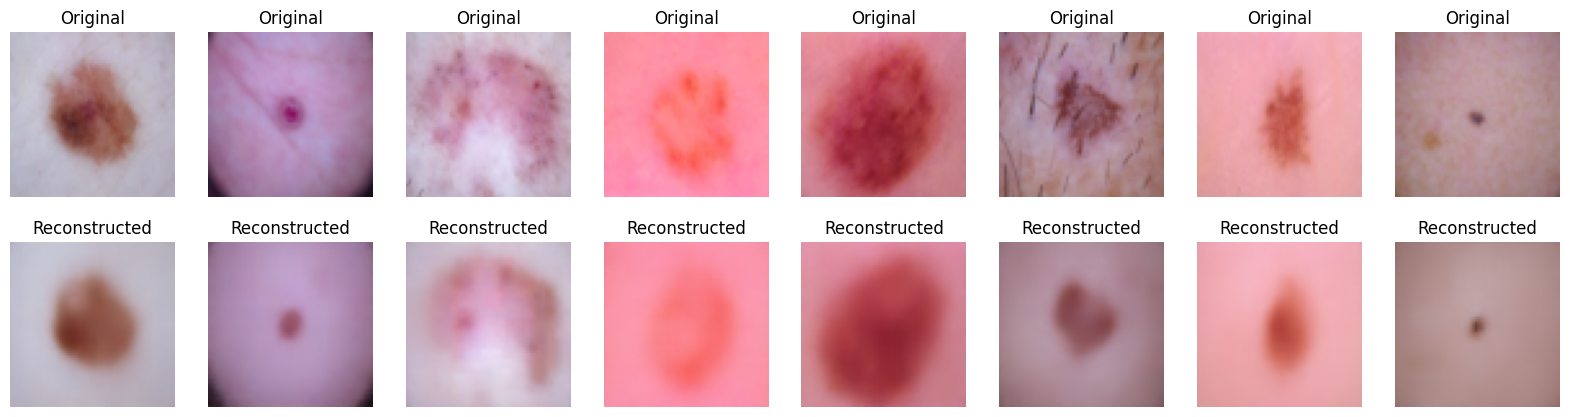

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Load a batch from the last reconstruction
vae.eval()
with torch.no_grad():
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        recon, _, _ = vae(imgs)
        break  # take only first batch

# Denormalize images from [-1,1] to [0,1]
recon = (recon + 1)/2
imgs = (imgs + 1)/2

# Display first 8 images: original vs reconstruction
fig, axes = plt.subplots(2, 8, figsize=(20,5))
for i in range(8):
    axes[0,i].imshow(imgs[i].permute(1,2,0).cpu())
    axes[0,i].axis('off')
    axes[0,i].set_title('Original')

    axes[1,i].imshow(recon[i].permute(1,2,0).cpu())
    axes[1,i].axis('off')
    axes[1,i].set_title('Reconstructed')

plt.show()

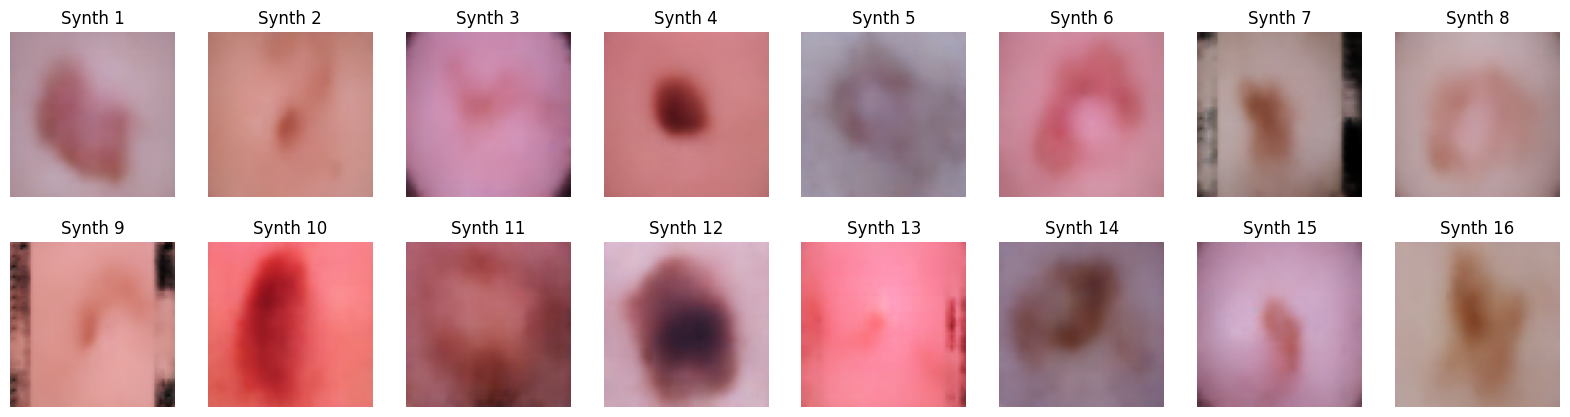

In [ ]:
# Take first 16 synthetic images from outputs/fid_samples/vae/
import torchvision.io as io

synthetic_paths = sorted(glob.glob("outputs/fid_samples/vae/*.png"))[:16]

fig, axes = plt.subplots(2, 8, figsize=(20,5))
for i, path in enumerate(synthetic_paths):
    img = Image.open(path)
    axes[i//8, i%8].imshow(img)
    axes[i//8, i%8].axis('off')
    axes[i//8, i%8].set_title(f'Synth {i+1}')
plt.show()

In [ ]:
!pip install pytorch-fid

from pytorch_fid import fid_score

real_path = combined_path        # original images (augmented set)
fake_path = "outputs/fid_samples/vae"  # generated images

fid_value = fid_score.calculate_fid_given_paths([real_path, fake_path],
                                                batch_size=50,
                                                device=device,
                                                dims=2048)
print("FID:", fid_value)

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


100%|██████████| 91.2M/91.2M [00:04<00:00, 21.0MB/s]
100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


FID: 250.9843103139115


In [ ]:
!pip install torch-fidelity

In [ ]:
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 60.2 MB/s eta 0:00:00


In [ ]:
!pip install piq

import piq
# imgs: original batch, recon: reconstructed batch from VAE
ssim_score = piq.ssim(recon, imgs).item()
print("SSIM:", ssim_score)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 8.8 MB/s eta 0:00:00
SSIM: 0.8099541068077087


In [ ]:
!pip install lpips

import lpips
loss_fn = lpips.LPIPS(net='alex').to(device)
lpips_score = loss_fn(recon, imgs).mean().item()
print("LPIPS:", lpips_score)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.0 MB/s eta 0:00:00
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 203MB/s]


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS: 0.1838383674621582


In [ ]:
!pip install torch-fidelity

from torch_fidelity import calculate_metrics

real_path = combined_path  # your original images folder
fake_path = "outputs/fid_samples/vae"  # VAE generated images

metrics = calculate_metrics(
    input1=real_path,
    input2=fake_path,
    cuda=True,
    isc=True,      # Inception Score
    kid=False,
    verbose=True
)

print("Inception Score:", metrics['inception_score_mean'], "±", metrics['inception_score_std'])

Creating feature extractor "inception-v3-compat" with features ['logits_unbiased']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 308MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "/content/HAM10000/images" with extensions png,jpg,jpeg
Found 20000 samples, some are lossy-compressed - this may affect metrics
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/

Inception Score: 3.3009946624304844 ± 0.08703198208008638


Inception Score: 3.3009946624304844 ± 0.08703198208008638


In [ ]:
# =====================================
# Save Metrics to Google Drive
# =====================================
from google.colab import drive
import os, json
import torch # Import torch to check for tensors

drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/AI_Comparisons/VAE_Results'
os.makedirs(save_dir, exist_ok=True)

# Example metrics you might have
# train_losses = [...]
# val_losses = [...]
# fid_scores = [...]
# ssim_scores = [...]

metrics = {
    "train_losses": train_losses if 'train_losses' in locals() else None,
    "fid_value": fid_value if 'fid_value' in locals() else None,
    "ssim_score": ssim_score if 'ssim_score' in locals() else None,
    "lpips_score": lpips_score if 'lpips_score' in locals() else None,
    "epochs": epochs if 'epochs' in locals() else None
}

# Convert tensor values to floats
for key, value in metrics.items():
    if isinstance(value, torch.Tensor):
        metrics[key] = value.item()

with open(f"{save_dir}/vae_results.json", "w") as f:
    json.dump(metrics, f, indent=4)

print(f"Metrics saved to: {save_dir}/vae_results.json")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Metrics saved to: /content/drive/MyDrive/AI_Comparisons/VAE_Results/vae_results.json


In [ ]:
# =============================
# SAVE RESULTS TO GOOGLE DRIVE
# =============================

from google.colab import drive
drive.mount('/content/drive')

import os, shutil

MODEL_NAME = "vae"   # <-- keep this "vae" for this notebook
drive_base = f"/content/drive/MyDrive/colab-outputs/{MODEL_NAME}"
os.makedirs(drive_base, exist_ok=True)

# Copy generated images and logs
if os.path.exists("/content/outputs/samples"):
    shutil.copytree("/content/outputs/samples", f"{drive_base}/samples", dirs_exist_ok=True)
if os.path.exists("/content/outputs/training_log.csv"):
    shutil.copy("/content/outputs/training_log.csv", f"{drive_base}/training_log.csv")
if os.path.exists("/content/outputs/metrics.csv"):
    shutil.copy("/content/outputs/metrics.csv", f"{drive_base}/metrics.csv")

print(f"✅ All VAE outputs and logs saved to Drive at: {drive_base}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ All VAE outputs and logs saved to Drive at: /content/drive/MyDrive/colab-outputs/vae


In [ ]:
# =============================
# SAVE EACH GENERATED IMAGE TO GOOGLE DRIVE
# =============================

from google.colab import drive
import shutil, os, glob

# Mount Google Drive
drive.mount('/content/drive')

# Define source and target directories
source_dir = "/content/outputs/fid_samples/vae"  # folder where generated images are stored
target_dir = "/content/drive/MyDrive/VAE_outputs/generated_images"

# Create target directory in Drive
os.makedirs(target_dir, exist_ok=True)

# Copy each image one-by-one
image_files = sorted(glob.glob(os.path.join(source_dir, "*.png")))  # change to .jpg if needed
for img_path in image_files:
    shutil.copy(img_path, target_dir)

print(f"✅ Copied {len(image_files)} generated images to: {target_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Copied 1000 generated images to: /content/drive/MyDrive/VAE_outputs/generated_images


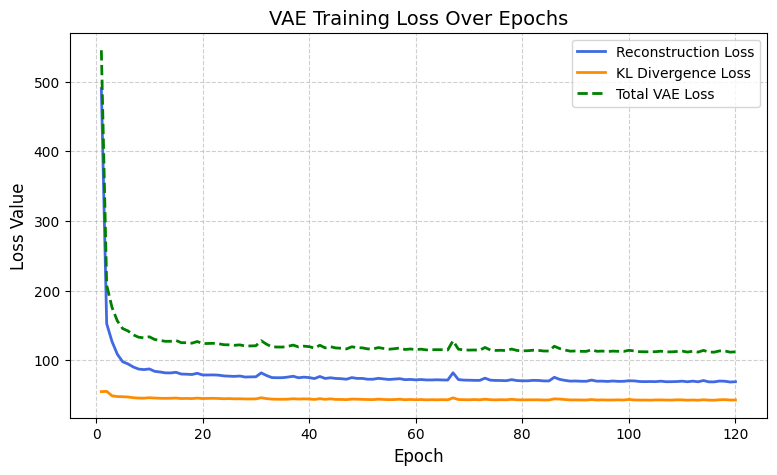

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to your metrics file
csv_path = "/content/drive/MyDrive/VAE_outputs/metrics.csv"  # change path if needed

# Assign column names manually
columns = [
    'model', 'epoch', 'timestamp',
    'recon_loss', 'kl_loss', 'total_vae_loss',
    'fid', 'ssim', 'lpips', 'inception', 'notes'
]

# Load the CSV
df = pd.read_csv(csv_path, header=None, names=columns)

# Drop duplicates if the same epoch is logged multiple times
df = df.drop_duplicates(subset='epoch', keep='last')

# Convert epoch to integer (sometimes gets read as string)
df['epoch'] = df['epoch'].astype(int)

# Plot
plt.figure(figsize=(9,5))
plt.plot(df['epoch'], df['recon_loss'], label='Reconstruction Loss', color='royalblue', linewidth=2)
plt.plot(df['epoch'], df['kl_loss'], label='KL Divergence Loss', color='darkorange', linewidth=2)
plt.plot(df['epoch'], df['total_vae_loss'], label='Total VAE Loss', color='green', linestyle='--', linewidth=2)

plt.title("VAE Training Loss Over Epochs", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

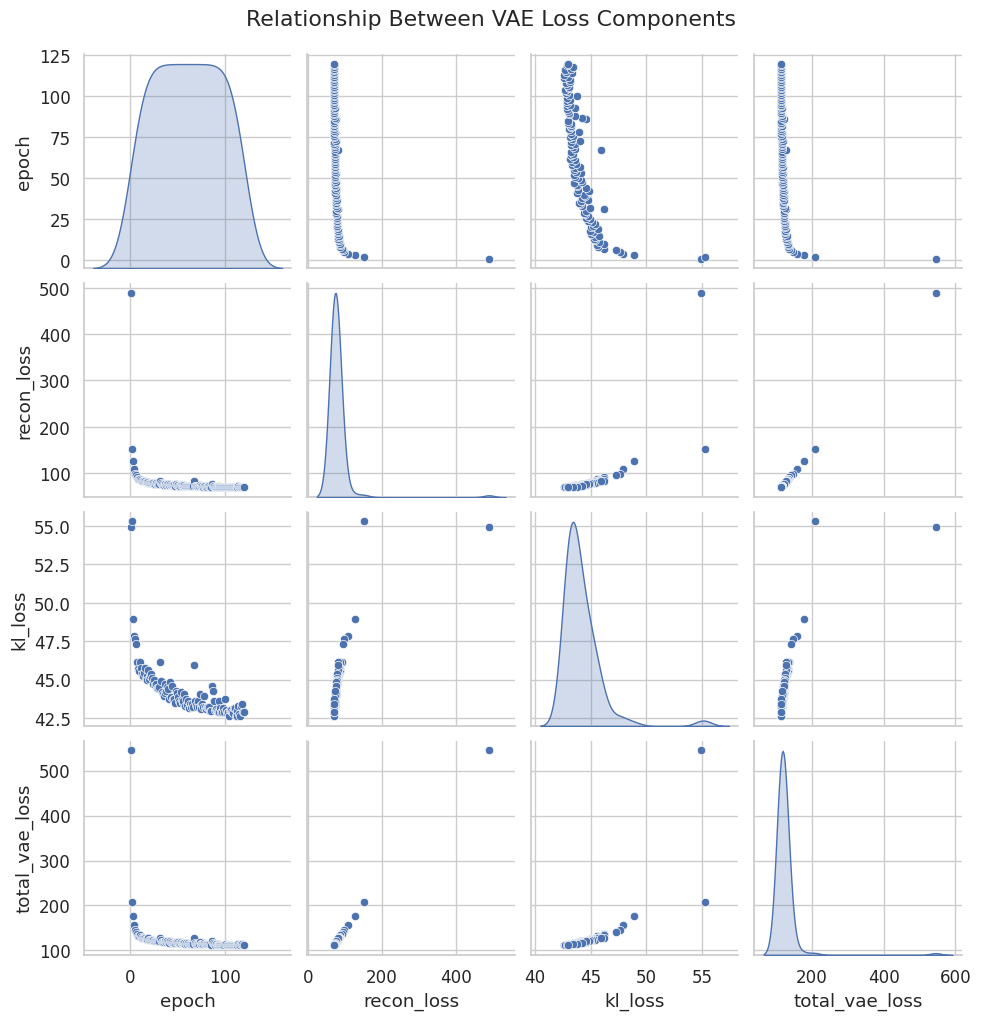

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Load CSV ===
csv_path = "/content/drive/MyDrive/VAE_outputs/metrics.csv"  # or your drive path
columns = ['model', 'epoch', 'timestamp', 'recon_loss', 'kl_loss', 'total_vae_loss',
            'fid', 'ssim', 'lpips', 'inception', 'notes']

df = pd.read_csv(csv_path, header=None, names=columns)
df = df.drop_duplicates(subset='epoch', keep='last')
df['epoch'] = df['epoch'].astype(int)

# === Basic setup ===
sns.set(style="whitegrid", font_scale=1.1)
save_dir = "/content/drive/MyDrive/VAE_outputs"
os.makedirs(save_dir, exist_ok=True)

# =======================
# COMBINED OVERVIEW (Pairplot)
# =======================
selected = df[['epoch', 'recon_loss', 'kl_loss', 'total_vae_loss']]
sns.pairplot(selected, diag_kind='kde')
plt.suptitle("Relationship Between VAE Loss Components", y=1.02)
plt.savefig(f"{save_dir}/vae_pairplot.png")
plt.show()

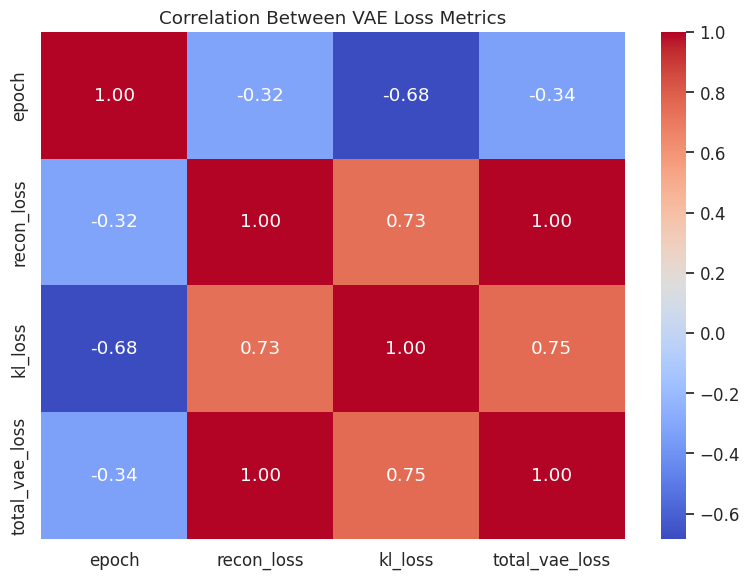

✅ All graphs saved to: /content/drive/MyDrive/VAE_outputs


In [ ]:
# =======================
# CORRELATION HEATMAP
# =======================
plt.figure(figsize=(8,6))
sns.heatmap(selected.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between VAE Loss Metrics")
plt.tight_layout()
plt.savefig(f"{save_dir}/vae_correlation_heatmap.png")
plt.show()

print(f"✅ All graphs saved to: {save_dir}")